<a href="https://colab.research.google.com/github/code-r28/Deep-Learning-Enhanced-Diagnostic-Systems-Integrating-Convolutional-Neural-Networks-and-Grad-CAM/blob/main/INT_400.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


pio.renderers.default = 'notebook'
from distutils.dir_util import copy_tree, remove_tree
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image, ImageFilter, ImageEnhance
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50V2


from keras.applications.densenet import DenseNet201
from keras.layers import LeakyReLU

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.17.0


In [ ]:

base_dir = '/Users/khamesh/Downloads/Monkeypox Skin Lesion Dataset/Fold1/Fold1/Fold1'
print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/Train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/Val'))

Contents of base directory:
['.DS_Store', 'Test', 'Train', 'Val']

Contents of train directory:
['.DS_Store', 'Others', 'Monkeypox']

Contents of validation directory:
['.DS_Store', 'Others', 'Monkeypox']


In [ ]:

base_dir = '/Users/khamesh/Downloads/Monkeypox Skin Lesion Dataset/Augmented Images'
base_val = '/Users/khamesh/Downloads/Monkeypox Skin Lesion Dataset/Fold1/Fold1/Fold1'


train_dir = os.path.join(base_dir, 'Augmented Images')
validation_dir = os.path.join(base_val, 'Val')


train_monkeypox_dir = os.path.join(train_dir,"Monkeypox_augmented")
train_non_monkeypox_dir = os.path.join(train_dir,"Others_augmented")
validation_monkeypox_dir = os.path.join(validation_dir,"Monkeypox")
validation_non_monkeypox_dir = os.path.join(validation_dir,"Others")

In [ ]:

print('Total Training Monkeypox Images:', len(os.listdir(train_monkeypox_dir)))
print('Total Training Non_Monkeypox Images:', len(os.listdir(train_non_monkeypox_dir)))

print('Total Validation Monkeypox Images:', len(os.listdir(validation_monkeypox_dir)))
print('Total Validation Non_Monkeypox Images:', len(os.listdir(validation_non_monkeypox_dir)))

Total Training Monkeypox Images: 1428
Total Training Non_Monkeypox Images: 1764
Total Validation Monkeypox Images: 168
Total Validation Non_Monkeypox Images: 252


In [ ]:

train_datagen = IDG(rescale = 1.0/255.,)
                    # rotation_range = 40,
                    # width_shift_range = 0.2,
                    # height_shift_range = 0.2,
                    # shear_range = 0.2,
                    # zoom_range = [.99, 1.01],
                    # brightness_range = [0.8, 1.2],
                    # data_format = "channels_last",
                    # fill_mode = "constant",
                    # horizontal_flip = True )

validation_datagen  = IDG( rescale = 1.0/255.,
                    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 3350,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                               batch_size = 612,
                                                               class_mode  = 'categorical',
                                                               target_size = (224, 224))

test_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size = 122,
                                                         subset='validation',
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 3192 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 83 images belonging to 2 classes.


In [ ]:

train_data, train_labels = next(train_generator)
val_data, val_labels = next(validation_generator)
test_data, test_labels = next(test_generator)

In [ ]:

print("Training Data Shape:", train_data.shape)
print("Training Labels Shape:", train_labels.shape)
print("\n")
print("Validation Data Shape:", val_data.shape)
print("Validation Labels Shape:", val_labels.shape)
print("\n")
print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels.shape)

Training Data Shape: (3192, 224, 224, 3)
Training Labels Shape: (3192, 2)


Validation Data Shape: (420, 224, 224, 3)
Validation Labels Shape: (420, 2)


Test Data Shape: (83, 224, 224, 3)
Test Labels Shape: (83, 2)


In [ ]:


import urllib.request


local_weights_file_url = 'https://storage.googleapis.com/tensorflow/keras-applications/densenet/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5'


local_weights_file = 'densenet201_weights_tf.h5'
urllib.request.urlretrieve(local_weights_file_url, local_weights_file)


pre_trained_model = DenseNet201(input_shape=(224, 224, 3),
                                include_top=False,
                                weights=None)


pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

In [ ]:
"""pre_trained_model = DenseNet201(input_shape=(224, 224, 3),
                                include_top=False,
                                weights='imagenet')"""

"pre_trained_model = DenseNet201(input_shape=(224, 224, 3),\n                                include_top=False,\n                                weights='imagenet')"

In [ ]:

pre_trained_model.summary()

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,321,984 (69.89 MB)

In [ ]:

last_layer = pre_trained_model.get_layer('conv5_block16_0_bn')


print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 1376)


In [ ]:
#  1 dimension
x = tf.keras.layers.Flatten()(last_output)
#  ReLU activation
x = tf.keras.layers.Dense(256, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)
# final sigmoid layer
x = tf.keras.layers.Dense  (2, activation='sigmoid')(x)

# Append
model = Model(pre_trained_model.input, x)
#  file extension from .h5 to .keras
cb = [EarlyStopping(patience=10,monitor='val_accuracy',mode='max',restore_best_weights=True),ModelCheckpoint("ResNet50V2-01.keras",save_best_only=True)]


In [ ]:
# neural network model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Training the model
history = model.fit(
      train_data,
      train_labels,
      epochs=50,
      validation_data=(val_data, val_labels),
      callbacks = cb)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.7796 - loss: 0.5133 - val_accuracy: 0.9190 - val_loss: 0.2069
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.9567 - loss: 0.1233 - val_accuracy: 0.9643 - val_loss: 0.0927
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.9845 - loss: 0.0612 - val_accuracy: 0.9810 - val_loss: 0.0584
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.9953 - loss: 0.0310 - val_accuracy: 0.8833 - val_loss: 0.3123
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - accuracy: 0.9891 - loss: 0.0358 - val_accuracy: 0.9881 - val_loss: 0.0450
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.9926 - loss: 0.0244 - val_accuracy: 0.9762 - val_loss: 0.0612
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.9989 - loss: 0.0088 - val_accuracy: 0.9786 - val_loss: 0.0508
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.9998 - loss: 0.0035 - val_accu

KeyboardInterrupt: 

In [ ]:
# Evaluating the model
test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9880 - loss: 0.0659
Testing Accuracy: 97.59%


In [ ]:


CLASSES = ['Monkeypox_augmented', 'Others_augmented']


pred_labels = model.predict(test_data)

def roundoff(arr):
    """Rounds off the predicted probabilities to binary (one-hot encoded) values."""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr


for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step
                     precision    recall  f1-score   support

Monkeypox_augmented       0.94      1.00      0.97        33
   Others_augmented       1.00      0.96      0.98        50

          micro avg       0.98      0.98      0.98        83
          macro avg       0.97      0.98      0.98        83
       weighted avg       0.98      0.98      0.98        83
        samples avg       0.98      0.98      0.98        83



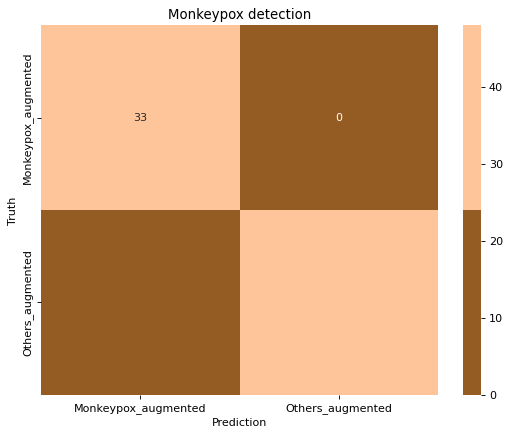

In [ ]:

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

cmap = sns.color_palette(["#945c23", "#fec59b"], as_cmap=True)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap=cmap, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Monkeypox detection')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


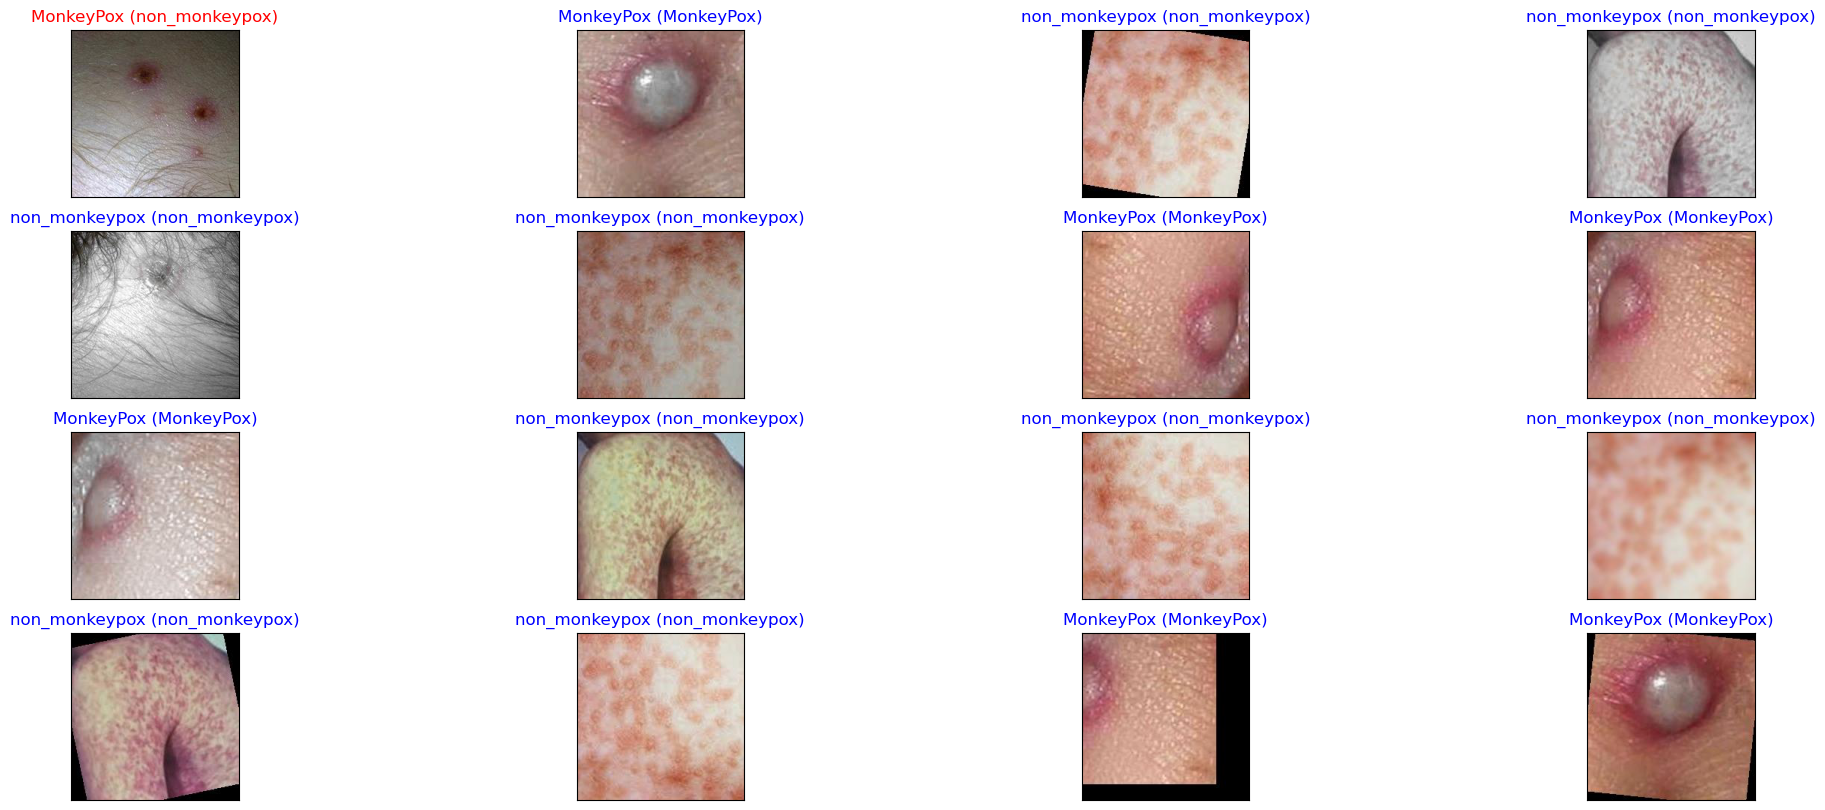

In [ ]:
y_hat = model.predict(test_data)

m_labels = ['MonkeyPox','non_monkeypox']

fig = plt.figure(figsize=(25, 10))
for i, idx in enumerate(np.random.choice(test_data.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_data[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(test_labels[idx])
    ax.set_title("{} ({})".format(m_labels[pred_idx], m_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))
    model.save('monkeypox_model_t.h5')

In [ ]:
model.save('monkeypox_model_t.h5')

In [ ]:

test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9880 - loss: 0.0659
Testing Accuracy: 97.59%


2024-10-21 18:56:15.474 python[33438:1203157] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-21 18:56:16.469 python[33438:1203157] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


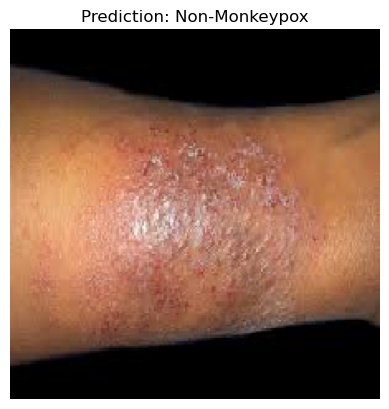

'Non-Monkeypox'

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import matplotlib.pyplot as plt


def predict_image(model):
    # Open as file dialog
    Tk().withdraw()
    img_path = askopenfilename()


    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0


    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)


    class_labels = ['Monkeypox', 'Non-Monkeypox']
    result = class_labels[predicted_class]


    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {result}")
    plt.show()

    return result


predict_image(model)


2024-10-21 18:59:16.477 python[33438:1203157] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


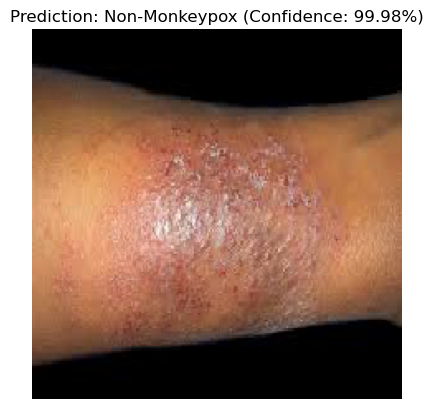

Predicted Class: Non-Monkeypox, Confidence Score: 99.98%


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import matplotlib.pyplot as plt

def predict_image_with_confidence(model):

    Tk().withdraw()
    img_path = askopenfilename()

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence_score = np.max(prediction)


    class_labels = ['Monkeypox', 'Non-Monkeypox']
    result = class_labels[predicted_class]


    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {result} (Confidence: {confidence_score * 100:.2f}%)")
    plt.show()

    return result, confidence_score


result, confidence = predict_image_with_confidence(model)
print(f"Predicted Class: {result}, Confidence Score: {confidence * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


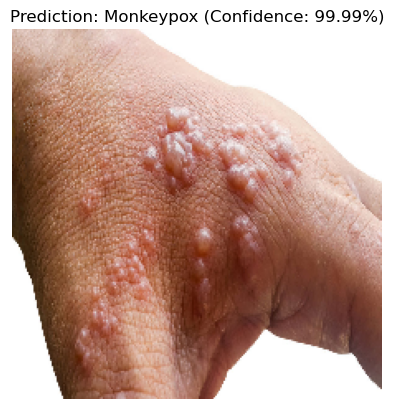

Predicted Class: Monkeypox, Confidence Score: 99.99%


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import matplotlib.pyplot as plt


def predict_image_with_confidence(model):

    Tk().withdraw()
    img_path = askopenfilename()


    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence_score = np.max(prediction)

    class_labels = ['Monkeypox', 'Non-Monkeypox']
    result = class_labels[predicted_class]


    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {result} (Confidence: {confidence_score * 100:.2f}%)")
    plt.show()

    return result, confidence_score


result, confidence = predict_image_with_confidence(model)
print(f"Predicted Class: {result}, Confidence Score: {confidence * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


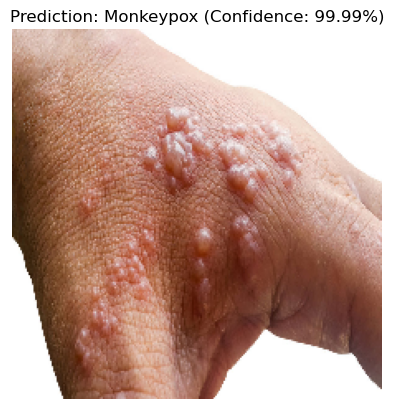

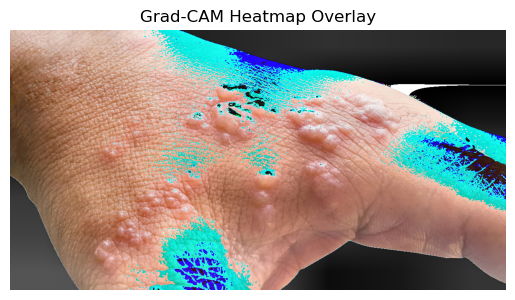

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tkinter import Tk
from tkinter.filedialog import askopenfilename


def predict_with_gradcam(model, last_conv_layer_name):

    Tk().withdraw()
    img_path = askopenfilename()

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0


    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    class_labels = ['Monkeypox', 'Non-Monkeypox']
    result = class_labels[predicted_class]


    gradcam_heatmap = generate_gradcam_heatmap(model, img_array, last_conv_layer_name, predicted_class)


    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {result} (Confidence: {np.max(prediction) * 100:.2f}%)")
    plt.show()


    overlay_gradcam_on_image(img_path, gradcam_heatmap)

    return result, np.max(prediction)


def generate_gradcam_heatmap(model, img_array, last_conv_layer_name, predicted_class):
    # model's final convolutional layer
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # gradients of the last convolutional layer
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, predicted_class]  # Focus on the predicted class
        grads = tape.gradient(loss, conv_output)  # Compute the gradients

    # Compute the guided gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]


    conv_output = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(conv_output)


    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


def overlay_gradcam_on_image(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = image.load_img(img_path)
    img = image.img_to_array(img)


    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)  # Add extra dimension for broadcasting
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1]))

    # Convert heatmap to RGB (by replicating across the RGB channels)
    heatmap = np.repeat(heatmap, 3, axis=-1)

    # Superimpose the heatmap on the original image
    overlay = heatmap * alpha + img
    overlay = np.uint8(overlay)

    # Display the image with Grad-CAM overlay
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap Overlay")
    plt.show()

# Call the function with the last convolutional layer name (adjust for your model)
result, confidence = predict_with_gradcam(model, last_conv_layer_name='conv5_block16_0_bn')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


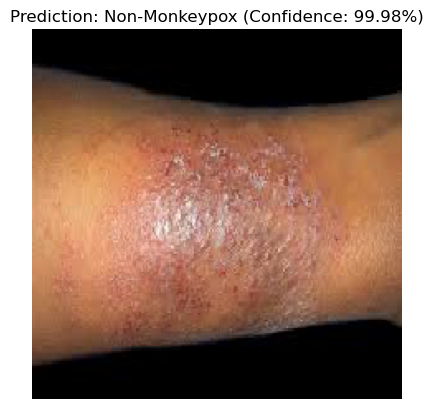

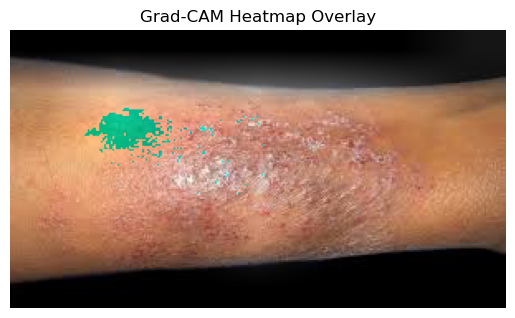

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Function to preprocess and make predictions with Grad-CAM
def predict_with_gradcam(model, last_conv_layer_name):
    # Open a file dialog to choose the image
    Tk().withdraw()  # Prevents the Tkinter window from appearing
    img_path = askopenfilename()  # Opens a file dialog

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values

    # Make prediction and get the predicted class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Define class labels (adjust these based on your labels)
    class_labels = ['Monkeypox', 'Non-Monkeypox']
    result = class_labels[predicted_class]

    # Generate Grad-CAM heatmap
    gradcam_heatmap = generate_gradcam_heatmap(model, img_array, last_conv_layer_name, predicted_class)

    # Display image, prediction, and confidence score
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {result} (Confidence: {np.max(prediction) * 100:.2f}%)")
    plt.show()

    # Overlay Grad-CAM heatmap on the image
    overlay_gradcam_on_image(img_path, gradcam_heatmap)

    return result, np.max(prediction)

# Function to generate Grad-CAM heatmap
def generate_gradcam_heatmap(model, img_array, last_conv_layer_name, predicted_class):
    # Get the model's final convolutional layer
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Get the gradients of the last convolutional layer
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, predicted_class]  # Focus on the predicted class
        grads = tape.gradient(loss, conv_output)  # Compute the gradients

    # Compute the guided gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]

    # Weight the convolutional outputs by the pooled gradients
    conv_output = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(conv_output)

    # Normalize the heatmap between 0 and 1 for visualization
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Function to overlay Grad-CAM heatmap on the image
def overlay_gradcam_on_image(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Resize heatmap to match the size of the original image
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)  # Add extra dimension for broadcasting
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1]))

    # Convert heatmap to RGB (by replicating across the RGB channels)
    heatmap = np.repeat(heatmap, 3, axis=-1)

    # Superimpose the heatmap on the original image
    overlay = heatmap * alpha + img
    overlay = np.uint8(overlay)

    # Display the image with Grad-CAM overlay
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap Overlay")
    plt.show()

# Call the function with the last convolutional layer name (adjust for your model)
result, confidence = predict_with_gradcam(model, last_conv_layer_name='conv5_block16_0_bn')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


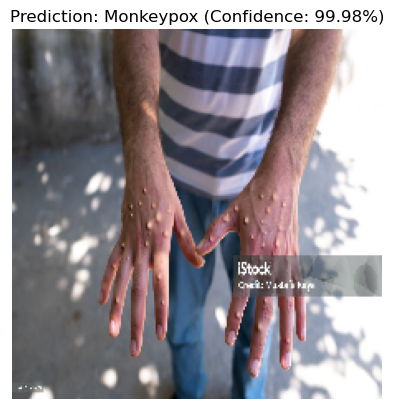

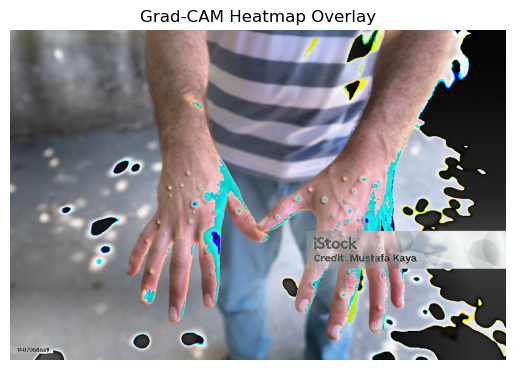

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Function to preprocess and make predictions with Grad-CAM
def predict_with_gradcam(model, last_conv_layer_name):
    # Open a file dialog to choose the image
    Tk().withdraw()  # Prevents the Tkinter window from appearing
    img_path = askopenfilename()  # Opens a file dialog

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values

    # Make prediction and get the predicted class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Define class labels (adjust these based on your labels)
    class_labels = ['Monkeypox', 'Non-Monkeypox']
    result = class_labels[predicted_class]

    # Generate Grad-CAM heatmap
    gradcam_heatmap = generate_gradcam_heatmap(model, img_array, last_conv_layer_name, predicted_class)

    # Display image, prediction, and confidence score
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {result} (Confidence: {np.max(prediction) * 100:.2f}%)")
    plt.show()

    # Overlay Grad-CAM heatmap on the image
    overlay_gradcam_on_image(img_path, gradcam_heatmap)

    return result, np.max(prediction)

# Function to generate Grad-CAM heatmap
def generate_gradcam_heatmap(model, img_array, last_conv_layer_name, predicted_class):
    # Get the model's final convolutional layer
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Get the gradients of the last convolutional layer
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, predicted_class]  # Focus on the predicted class
        grads = tape.gradient(loss, conv_output)  # Compute the gradients

    # Compute the guided gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]

    # Weight the convolutional outputs by the pooled gradients
    conv_output = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(conv_output)

    # Normalize the heatmap between 0 and 1 for visualization
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Function to overlay Grad-CAM heatmap on the image
def overlay_gradcam_on_image(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Resize heatmap to match the size of the original image
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)  # Add extra dimension for broadcasting
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1]))

    # Convert heatmap to RGB (by replicating across the RGB channels)
    heatmap = np.repeat(heatmap, 3, axis=-1)

    # Superimpose the heatmap on the original image
    overlay = heatmap * alpha + img
    overlay = np.uint8(overlay)

    # Display the image with Grad-CAM overlay
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap Overlay")
    plt.show()

# Call the function with the last convolutional layer name (adjust for your model)
result, confidence = predict_with_gradcam(model, last_conv_layer_name='conv5_block16_0_bn')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


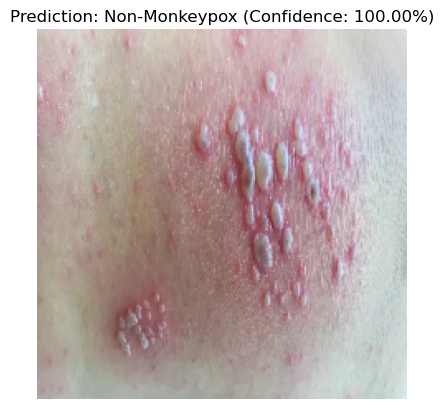

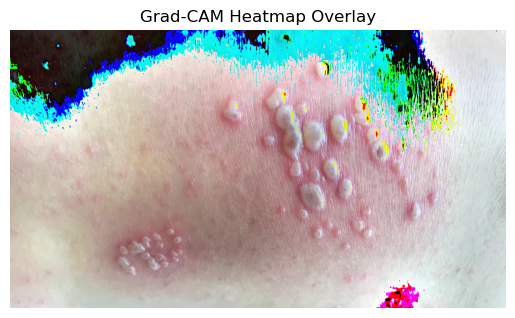

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Function to preprocess and make predictions with Grad-CAM
def predict_with_gradcam(model, last_conv_layer_name):
    # Open a file dialog to choose the image
    Tk().withdraw()  # Prevents the Tkinter window from appearing
    img_path = askopenfilename()  # Opens a file dialog

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values

    # Make prediction and get the predicted class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Define class labels (adjust these based on your labels)
    class_labels = ['Monkeypox', 'Non-Monkeypox']
    result = class_labels[predicted_class]

    # Generate Grad-CAM heatmap
    gradcam_heatmap = generate_gradcam_heatmap(model, img_array, last_conv_layer_name, predicted_class)

    # Display image, prediction, and confidence score
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {result} (Confidence: {np.max(prediction) * 100:.2f}%)")
    plt.show()

    # Overlay Grad-CAM heatmap on the image
    overlay_gradcam_on_image(img_path, gradcam_heatmap)

    return result, np.max(prediction)

# Function to generate Grad-CAM heatmap
def generate_gradcam_heatmap(model, img_array, last_conv_layer_name, predicted_class):
    # Get the model's final convolutional layer
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Get the gradients of the last convolutional layer
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, predicted_class]  # Focus on the predicted class
        grads = tape.gradient(loss, conv_output)  # Compute the gradients

    # Compute the guided gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]

    # Weight the convolutional outputs by the pooled gradients
    conv_output = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(conv_output)

    # Normalize the heatmap between 0 and 1 for visualization
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Function to overlay Grad-CAM heatmap on the image
def overlay_gradcam_on_image(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Resize heatmap to match the size of the original image
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)  # Add extra dimension for broadcasting
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1]))

    # Convert heatmap to RGB (by replicating across the RGB channels)
    heatmap = np.repeat(heatmap, 3, axis=-1)

    # Superimpose the heatmap on the original image
    overlay = heatmap * alpha + img
    overlay = np.uint8(overlay)

    # Display the image with Grad-CAM overlay
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap Overlay")
    plt.show()

# Call the function with the last convolutional layer name (adjust for your model)
result, confidence = predict_with_gradcam(model, last_conv_layer_name='conv5_block16_0_bn')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


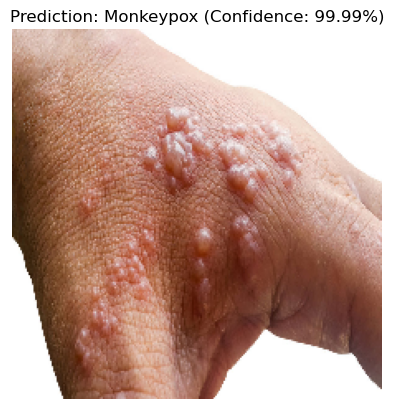

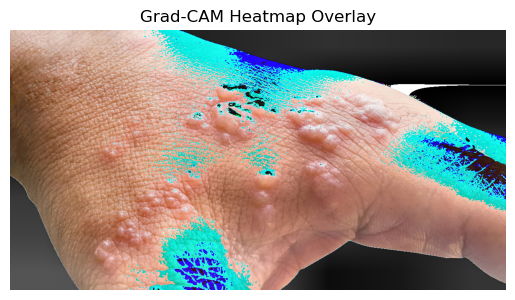

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Function to preprocess and make predictions with Grad-CAM
def predict_with_gradcam(model, last_conv_layer_name):
    # Open a file dialog to choose the image
    Tk().withdraw()  # Prevents the Tkinter window from appearing
    img_path = askopenfilename()  # Opens a file dialog

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values

    # Make prediction and get the predicted class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Define class labels (adjust these based on your labels)
    class_labels = ['Monkeypox', 'Non-Monkeypox']
    result = class_labels[predicted_class]

    # Generate Grad-CAM heatmap
    gradcam_heatmap = generate_gradcam_heatmap(model, img_array, last_conv_layer_name, predicted_class)

    # Display image, prediction, and confidence score
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {result} (Confidence: {np.max(prediction) * 100:.2f}%)")
    plt.show()

    # Overlay Grad-CAM heatmap on the image
    overlay_gradcam_on_image(img_path, gradcam_heatmap)

    return result, np.max(prediction)

# Function to generate Grad-CAM heatmap
def generate_gradcam_heatmap(model, img_array, last_conv_layer_name, predicted_class):
    # Get the model's final convolutional layer
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Get the gradients of the last convolutional layer
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, predicted_class]  # Focus on the predicted class
        grads = tape.gradient(loss, conv_output)  # Compute the gradients

    # Compute the guided gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]

    # Weight the convolutional outputs by the pooled gradients
    conv_output = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(conv_output)

    # Normalize the heatmap between 0 and 1 for visualization
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Function to overlay Grad-CAM heatmap on the image
def overlay_gradcam_on_image(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Resize heatmap to match the size of the original image
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)  # Add extra dimension for broadcasting
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1]))

    # Convert heatmap to RGB (by replicating across the RGB channels)
    heatmap = np.repeat(heatmap, 3, axis=-1)

    # Superimpose the heatmap on the original image
    overlay = heatmap * alpha + img
    overlay = np.uint8(overlay)

    # Display the image with Grad-CAM overlay
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap Overlay")
    plt.show()

# Call the function with the last convolutional layer name (adjust for your model)
result, confidence = predict_with_gradcam(model, last_conv_layer_name='conv5_block16_0_bn')
